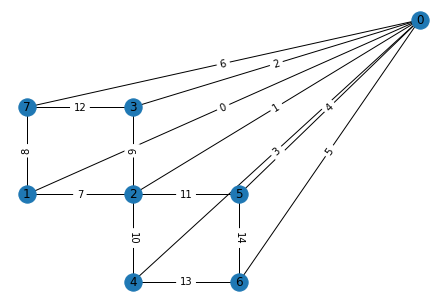

In [107]:
%run Final_Algorithm.ipynb
network,pos = Make_Question(3,3,Density = 0.85)
G = nx.DiGraph()
G = nx.from_numpy_array(network)
nx.draw(G,pos,with_labels=True)
edge_label = {}
for j, edge in enumerate(G.edges()):
    edge_label.update({(edge[0],edge[1]): str(j)})
a = nx.draw_networkx_edge_labels(G,pos,edge_labels =edge_label)

{(0, 1): '0', (0, 2): '1', (0, 3): '2', (0, 4): '3', (0, 5): '4', (0, 6): '5', (0, 7): '6', (1, 2): '7', (1, 7): '8', (2, 3): '9', (2, 4): '10', (2, 5): '11', (3, 7): '12', (4, 6): '13', (5, 6): '14'}


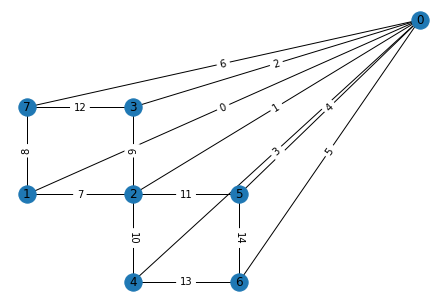

In [108]:
G, compelete_label = complete_Graph(network,pos)
print(compelete_label)

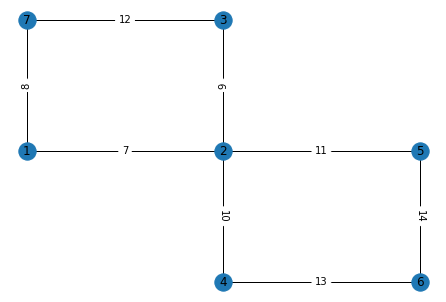

In [109]:
G_prime, sub_edge_label = sub_Graph (network,pos,compelete_label)

In [120]:
Final_map, lowest_edge_number = edge_map(G, compelete_label, sub_edge_label)
print(Final_map)
print(Final_map[lowest_edge_number:,lowest_edge_number:])
print(lowest_edge_number)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.]]
[[0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0.]]
7


In [111]:
basic_cost = np.vstack(np.ones(len(compelete_label)))
QUBO_Obj = Objective(pos,compelete_label,basic_cost,flow_cost = 1)

In [112]:
QUBO_Constraint_1 = Constraint_1(pos,compelete_label,Final_map,penalty = 50)

In [113]:
QUBO_Constraint_2 = Constraint_2(pos,compelete_label,Final_map,penalty = 50)

In [314]:
# the max and min number of subtrees with a capacity equal to t in T 
#m_t_u = np.round(0.55 * Q * np.ones(Q))
#m_t_l = np.round(0.25 * Q * np.ones(Q))

print(Q)
m_t_u = np.random.randint(1.2*Q, size=Q)
m_t_l = np.random.randint(1.2*Q, size=Q)

Bus_edge = lowest_edge_number
print(m_t_u,Bus_edge)

m_t_u_update = np.where(m_t_u>=Bus_edge, Bus_edge,  m_t_u)

print(m_t_u_update)

disturbance =0.0001  #optinal

svn_up = np.ceil(np.log2(Bus_edge-m_t_u_update + disturbance))

svn_up_update = np.where(svn_up>=0, svn_up,  0)

print(svn_up,svn_up_update)

QUBO_martix = np.zeros((number_of_edge*Q,number_of_edge*Q))


## (sum x_et)^2 - 2m_t^u sum(x_et) 
skeleton = np.zeros(Q)
skeleton[0] = 1
print(skeleton)
skeleton_x = np.tile(skeleton ,Bus_edge )
print(skeleton_x)
skeleton_final = np.zeros((Bus_edge*Q,Bus_edge*Q))
for i in range(Bus_edge*Q):
    skeleton_final[i,:] = skeleton_x
    skeleton_x = np.roll(skeleton_x, 1)

skeleton_final -= np.diag(2*np.tile(m_t_u ,Bus_edge))
QUBO_martix[:Bus_edge*Q,:Bus_edge*Q] += skeleton_final

    
## (sum x_ti)^2 - 2m_t^u sum(x_ti)
# Since x_it is not useful in QUBO, in order to make our life easy, we change our way to index our x_it by 
# switching the index of x_it from x_it to x_ti

temp = QUBO_martix
for t in range(Q):
    print(np.int(svn_up_update[t]))
    if np.int(svn_up_update[t])==0:
        continue
    temp = np.pad(temp, ((0, np.int(svn_up_update[t])), (0, np.int(svn_up_update[t]))), 'constant', constant_values=0)
    
    print(temp[-np.int(svn_up_update[t]):,-np.int(svn_up_update[t]):])

7
[0 0 4 5 6 7 6] 7
[0 0 4 5 6 7 6]
[  3.   3.   2.   2.   1. -13.   1.] [3. 3. 2. 2. 1. 0. 1.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.]
3
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
3
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
2
[[0. 0.]
 [0. 0.]]
2
[[0. 0.]
 [0. 0.]]
1
[[0.]]
0
1
[[0.]]


In [298]:
coeff = np.power(2,np.arange(3))
print(coeff)
b = np.outer(coeff,coeff)
#np.repeat(b ,Bus_edge )
b.flatten()

[1 2 4]


array([ 1,  2,  4,  2,  4,  8,  4,  8, 16], dtype=int32)

In [302]:
skeleton = np.zeros(Q)
skeleton[0] = 1
print(skeleton)
skeleton_x = np.tile(skeleton ,Bus_edge )
print(skeleton_x)
skeleton_final = np.zeros((Bus_edge*Q,Bus_edge*Q))
for i in range(Bus_edge*Q):
    skeleton_final[i,:] = skeleton_x
    skeleton_x = np.roll(skeleton_x, 1)

skeleton_final -= np.diag(2*np.tile(m_t_u ,Bus_edge))
print(skeleton_final[:18,:18])
print(skeleton_final.shape)

[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.]
[[-11.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
    1.   0.   0.   0.]
 [  0.  -5.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
    0.   1.   0.   0.]
 [  0.   0. -13.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
    0.   0.   1.   0.]
 [  0.   0.   0.  -3.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
    0.   0.   0.   1.]
 [  0.   0.   0.   0.  -5.   0.   0.   0.   0.   0.   0.   1.   0.   0.
    0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  -3.   0.   0.   0.   0.   0.   0.   1.   0.
    0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  -3.   0.   0.   0.   0.   0.   0.   1.
    0.   0.   0.   0.]
 [  1.   0.   0.   0.   0.   0.   0. -11.   0.   0.   0.   0.   0.   0.
    1.   0.   0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   0.  -5.   0.   0.   0.   0.

In [87]:
# Capacity set length = Q
# example T = np.ones(Q)
# 0: energy collector do not accept i_th level of input
# 1: energy collector accept i_th level of input

# Quote from paper

# "The concept of generalized here is not the same as that in the context of the network design problem 
#  where the vertices are clustered and only one vertex in each cluster has to be selected. 
# If we set p = 1, T = {t1, t2}, and ml_t = mu_t = m_t for t ∈ T, this formulation is exactly for the CRP."

# "Constraints guarantee that the solution must contain mt type t subtrees."

# allowable plug-in to energy collector
T = np.ones(Q)   # can change

#retrict trees
m_t = 3*T          # standard amout of trees 
m_upper = 5*np.ones(Q) * T
m_lower = 2*np.ones(Q) * T

Q = len(pos)-1  
number_of_edge = len(compelete_label)
    
#construct 2 terms independently
QUBO_matrix = np.diag(np.zeros(number_of_edge * Q))

print(m_upper)

[5. 5. 5. 5. 5. 5. 5.]


In [95]:
Q = len(pos)-1
print(Q)
number_of_edge = len(compelete_label)
flow_cost = 1


QUBO_martix = np.zeros((number_of_edge*Q,number_of_edge*Q))

basic_cost = np.vstack(np.ones(number_of_edge))
temp_1 = basic_cost*np.ones((number_of_edge,Q))
term_1 = np.diag(temp_1.flatten())

##
temp = np.multiply(np.ones((number_of_edge,Q)),flow_cost*np.arange(Q))
term_2 = np.diag(temp.flatten())
print(np.diag(term_2))


#objective
QUBO_martix = term_1 + term_2

print(Final_map)


7
[0. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 6. 0. 1. 2.
 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5.
 6. 0. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 6. 0. 1.
 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4.
 5. 6. 0. 1. 2. 3. 4. 5. 6.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 

In [99]:
# constraint 1
# QUBO matrix = 2 sum{m,i \in leaving edge}( sum{n,j \in Q}( x_ij*x_mn))     [term 2]
#             - 3 sum{e \in leaving edge}( sum{d \in Q}( x_ed))              [term 1]
#             + 1                                                            [term 3]
Penalty_1 = 50
#construct 2 terms independently
QUBO_matrix = np.diag(np.zeros(number_of_edge*Q))

for edge_out in Final_map:
    index_out = np.hstack(np.asarray(np.where(edge_out)))
    if len(index_out) == 0:
        continue
    q = np.arange(Q)
    
    #QUBO＿index = Q * quotient(index) + remainder (q) 
    QUBO_index_out = np.outer(index_out ,Q * np.ones(Q)) +  q
    QUBO_index_out_flatten = QUBO_index_out.reshape(1,-1)
    
    #print(index_out)
    #print(QUBO_index_out)

    # Generate corresponding index mesh grid
    QUBO_index_out_x,QUBO_index_out_y = np.meshgrid(QUBO_index_out_flatten,QUBO_index_out_flatten)
    
    QUBO_matrix_index_out_term_1 = np.concatenate((QUBO_index_out_x.reshape(-1,1), QUBO_index_out_y.reshape(-1,1)), axis=1)
    QUBO_matrix_index_out_term_2 = np.concatenate((QUBO_index_out_flatten.reshape(-1,1), QUBO_index_out_flatten.reshape(-1,1)), axis=1)
    #print(edge_out,index)
    #print(index)
    #print(np.outer(Q * np.ones(Q),q))
    #print(QUBO_matrix_index_term_2)
    #print(QUBO_matrix_index_term_1)
    
    # term 1
    for indices in QUBO_matrix_index_out_term_1:
        QUBO_matrix[indices[0].astype(int)][indices[1].astype(int)] -= 3
    
    # term 2
    for indices in QUBO_matrix_index_out_term_2:
        QUBO_matrix[indices[0].astype(int)][indices[1].astype(int)] += 2
    
    # term 3
    
    QUBO_matrix += 1
    
    
    
#term_2 = 
#print(QUBO_index_out_x)   
#print(QUBO_index_out_y)   
#print(QUBO_matrix_index_out_term_1)

#print(np.min(QUBO_matrix))
    #constraint_1 = 

In [84]:
Final_map

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 1., 0.

In [85]:
Final_map.T

array([[0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.

In [86]:
connection = np.logical_and(Final_map, Final_map.T)
connection.astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]])

In [233]:
# constraint 2 A
# QUBO matrix = 2 sum{m,i \in leaving edge}( sum{n,j \in Q}( x_ij*x_mn))     [term 2]
#             - 3 sum{e \in leaving edge}( sum{d \in Q}( x_ed))              [term 1]
#             + 1                                                            [term 3]
Penalty_2 = 50
#construct 2 terms independently
QUBO_matrix = np.diag(np.zeros(number_of_edge*Q))

for edge_out in Final_map:
    index_out = np.hstack(np.asarray(np.where(edge_out)))
    if len(index_out) == 0:
        continue
    q = np.arange(Q)
    
    #QUBO＿index = Q * quotient(index) + remainder (q) 
    QUBO_index_out = np.outer(index_out ,Q * np.ones(Q)) +  q
    QUBO_index_out_flatten = QUBO_index_out.reshape(1,-1)

    #print(QUBO_index)
    # Generate corresponding index mesh grid
    QUBO_index_out_x,QUBO_index_out_y = np.meshgrid(QUBO_index_out_flatten,QUBO_index_out_flatten)
    
    QUBO_matrix_index_out_term_1 = np.concatenate((QUBO_index_out_x.reshape(-1,1), QUBO_index_out_y.reshape(-1,1)), axis=1)
    QUBO_matrix_index_out_term_2 = np.concatenate((QUBO_index_out_flatten.reshape(-1,1), QUBO_index_out_flatten.reshape(-1,1)), axis=1)

    
    # term (A-1)_1
    for indices in QUBO_matrix_index_out_term_1:
        QUBO_matrix[indices[0].astype(int)][indices[1].astype(int)] += 2*(indices[0].astype(int)%Q)*(indices[1].astype(int)%Q)
    
    # term (A-1)_2
    for indices in QUBO_matrix_index_out_term_2:
        QUBO_matrix[indices[0].astype(int)][indices[1].astype(int)] -= 2*((indices[0].astype(int)%Q+1)**2-1)
    
    # term (A-1)_3
    
    QUBO_matrix += 1
    
    
for edge_in in Final_map.T:
    index_in = np.hstack(np.asarray(np.where(edge_in)))
    if len(index_in) == 0:
        continue
    q = np.arange(Q)
    
    #QUBO＿index = Q * quotient(index) + remainder (q) 
    QUBO_index_in = np.outer(index_in ,Q * np.ones(Q)) +  q
    QUBO_index_in_flatten = QUBO_index_in.reshape(1,-1)
    
    #print(QUBO_index_in)

    # Generate corresponding index mesh grid
    QUBO_index_in_x,QUBO_index_in_y = np.meshgrid(QUBO_index_in_flatten,QUBO_index_in_flatten)
    
    QUBO_matrix_index_in_term_1 = np.concatenate((QUBO_index_in_x.reshape(-1,1), QUBO_index_in_y.reshape(-1,1)), axis=1)
    QUBO_matrix_index_in_term_2 = np.concatenate((QUBO_index_in_flatten.reshape(-1,1), QUBO_index_in_flatten.reshape(-1,1)), axis=1)
    #print(edge_out,index)
    #print(index)
    #print(np.outer(Q * np.ones(Q),q))
    #print(QUBO_matrix_index_term_2)
    #print(QUBO_matrix_index_term_1)
    
    # term (B-1)_1
    for indices in QUBO_matrix_index_in_term_1:
        QUBO_matrix[indices[0].astype(int)][indices[1].astype(int)] += 2*(indices[0].astype(int)%Q)*(indices[1].astype(int)%Q)
    
    # term (B-1)_2
    for indices in QUBO_matrix_index_in_term_2:
        QUBO_matrix[indices[0].astype(int)][indices[1].astype(int)] -= 2*((indices[0].astype(int)%Q+1)**2-1)
    
    # term (B-1)_3 + last term (-1)
    
    # QUBO_matrix += 1-1  (zero)
    
    # term 4B
    
    for indices in QUBO_matrix_index_out_term_2:
        QUBO_matrix[indices[0].astype(int)][indices[1].astype(int)] += 4*(indices[0].astype(int)%Q)

        
# term 2AB
for i in range(len(Final_map)):
    index_x = np.hstack(np.asarray(np.where(Final_map[i,:])))
    index_y = np.hstack(np.asarray(np.where(Final_map[:,i])))
    if len(index_x)*len(index_y) == 0:
        continue
    q = np.arange(Q)
    #print(index_x,index_y)
    
    #QUBO＿index = Q * quotient(index) + remainder (q) 
    QUBO_index_x = np.outer(index_x ,Q * np.ones(Q)) +  q
    QUBO_index_x_flatten = QUBO_index_x.reshape(1,-1)
    
    #QUBO＿index = Q * quotient(index) + remainder (q) 
    QUBO_index_y = np.outer(index_y ,Q * np.ones(Q)) +  q
    QUBO_index_y_flatten = QUBO_index_y.reshape(1,-1)
        
    #print( QUBO_index_x_flatten,  QUBO_index_y_flatten)
    
    QUBO_index_x,QUBO_index_y = np.meshgrid(QUBO_index_x_flatten,QUBO_index_y_flatten)
    
    QUBO_matrix_index_xy = np.concatenate((QUBO_index_x.reshape(-1,1), QUBO_index_y.reshape(-1,1)), axis=1)
    
    #print(QUBO_matrix_index_xy)
    for indices in QUBO_matrix_index_xy:
        QUBO_matrix[indices[0].astype(int)][indices[1].astype(int)] -= 2*(indices[0].astype(int)%Q)*(indices[1].astype(int)%Q)
    
    

In [105]:
QUBO_matrix

array([[   8.,    8.,    8., ...,    8.,    8.,    8.],
       [   8.,   -8.,   24., ...,    8.,    8.,    8.],
       [   8.,   24.,  -24., ...,    8.,    8.,    8.],
       ...,
       [   8.,   16.,   24., ..., -152.,  168.,  200.],
       [   8.,   18.,   28., ...,  168., -212.,  248.],
       [   8.,   20.,   32., ...,  200.,  248., -280.]])

In [75]:
Final_map[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [115]:
a = np.random.permutation(25).reshape(5,5)
print(a)
b_1 ,b_2= np.meshgrid(np.arange(5),np.arange(5))
index = np.concatenate((b_1.reshape(-1,1), b_2.reshape(-1,1)), axis=1)
for indices in index:
    
    a[indices[0]][indices[1]] -= 2 * np.prod(indices%7)
    #print(a[indices[0]][indices[1]])
    #print(2 * np.prod(indices%7))
    #print(indices)

#print(indices)
#print(a)

[[24 10 23 14 19]
 [ 7  5 21  2 15]
 [20 18 22  6  9]
 [ 4 11  0  8  3]
 [13 16 12 17  1]]


In [511]:
d = Q * np.ones(Q)
a = np.arange(Q)


#for edge_out in Final_map[7]:
edge_out = Final_map[7]
#print(np.where(edge_out))
index = np.hstack(np.asarray(np.where(edge_out)))
d = Q * np.ones(Q)

print(index,d)

k = np.outer(index,d)
print((len(index),Q))
print(k)
pp = k + a
print(pp)

[ 0  1  8  9 10 11] [7. 7. 7. 7. 7. 7. 7.]
(6, 7)
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 7.  7.  7.  7.  7.  7.  7.]
 [56. 56. 56. 56. 56. 56. 56.]
 [63. 63. 63. 63. 63. 63. 63.]
 [70. 70. 70. 70. 70. 70. 70.]
 [77. 77. 77. 77. 77. 77. 77.]]
[[ 0.  1.  2.  3.  4.  5.  6.]
 [ 7.  8.  9. 10. 11. 12. 13.]
 [56. 57. 58. 59. 60. 61. 62.]
 [63. 64. 65. 66. 67. 68. 69.]
 [70. 71. 72. 73. 74. 75. 76.]
 [77. 78. 79. 80. 81. 82. 83.]]


In [515]:
    
x = pp.flatten()
y = pp.flatten()
term_2_x,term_2_y = np.meshgrid(x,y)
print(xy)

[array([[ 0.,  1.,  2., ..., 81., 82., 83.],
       [ 0.,  1.,  2., ..., 81., 82., 83.],
       [ 0.,  1.,  2., ..., 81., 82., 83.],
       ...,
       [ 0.,  1.,  2., ..., 81., 82., 83.],
       [ 0.,  1.,  2., ..., 81., 82., 83.],
       [ 0.,  1.,  2., ..., 81., 82., 83.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       ...,
       [81., 81., 81., ..., 81., 81., 81.],
       [82., 82., 82., ..., 82., 82., 82.],
       [83., 83., 83., ..., 83., 83., 83.]])]


In [42]:
QUBO_martix.reshape(1,-1)

array([[1., 0., 0., ..., 0., 0., 7.]])